In [1]:
import sympy
import numpy             as np
import matplotlib.pyplot as plt

from sympy                    import *

# Introduction

In this script we solve the expansion equation as described in section 5 of the summary for the case of the Schwarzschild metric under the assumption of symmetry in $\theta$. The equation to be solved can be obtained via the symbolic solver in "AppHor_conformal.ipynb". For now we separate the linear part by hand (and set $\sin{\theta} = 1$ for simplicity) and we obtain
\begin{equation}
    A \cdot h = S(h) \quad \Leftrightarrow \quad 8\frac{d^2h}{d\phi^2} - 16h = -\frac{4M}{h} \frac{d^2h}{d\phi^2} - \frac{4M}{h^2} \left(\frac{dh}{d\phi}\right)^2 + \frac{24}{h} \left(\frac{dh}{d\phi}\right)^2 - 8M
\end{equation}
The approach is the following. For an arbitrary element in the $h$-array, say $h[i]$, we can set up the finite difference approximationof the left-hand-side of the above equation, giving
\begin{equation}
    h[i] \quad \rightarrow \quad \frac{8}{(\Delta\phi)^2} \left(h[i+1] - 2h[i] + h[i-1]\right) - 16h[i]
\end{equation}
Clearly this depends on both the previous and next element in the $h$-array. Repeating this for every $i$ results in a system of equations which can be represented by a tridiagonal matrix $A$. The only exceptions are the first and last row which have a reference to the last and first element of $h$ respectively, meaning there will be a non-zero element in the top-right and bottom-left position in the matrix.

All the required components (tridiagonal matrix for linear part, non-linear right-hand-side, ...) are constructed in the functions below, as well as the iterative solver.

In [2]:
'''
Define finite differences (central scheme) --> with periodic boundary conditions
'''

def der(h, delta, i):
    return ((h[(i+1)%N_ph] - h[i-1]) / (2*delta))

def der2(h, delta, i):
    return ((h[(i+1)%N_ph] - 2*h[i] + h[i-1]) / delta**2)



'''
Function which calculates RHS of expansion equation
'''

def rhs_update(h, delta):
    rhs = np.zeros(N_ph)
    for i in range(N_ph):
        rhs[i] = -8/h[i] * der2(h, delta, i) - 8/h[i]**2 * (der(h, delta, i))**2 + 24/h[i] * (der(h, delta, i))**2 - 16
    return rhs



'''
Construct tridiagonal matrix for the linear LHS
'''

def tridiag(n, a, b, c):
    main_diag = np.full(n, a)      # Main diagonal
    upper_diag = np.full(n-1, b)   # Upper diagonal
    lower_diag = np.full(n-1, c)   # Lower diagonal
    
    tridiagonal = np.diag(main_diag) + np.diag(upper_diag, k=1) + np.diag(lower_diag, k=-1)

    tridiagonal[0,n-1] = c   # to account for periodic BC (top-right element)
    tridiagonal[n-1,0] = b   # to account for periodic BC (bottom-left element)
    
    return tridiagonal

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


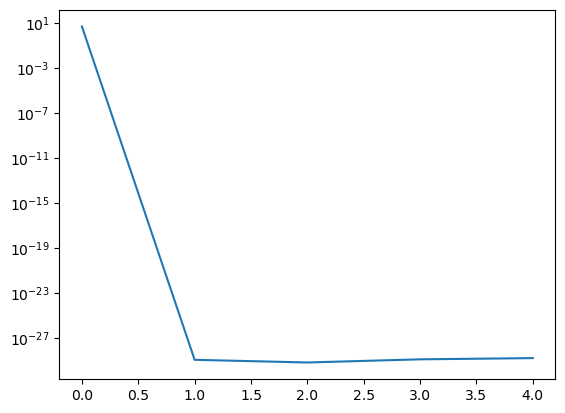

In [5]:
'''
Initialize data and tridiagonal matrix
'''
# Initialize data
N_ph = 50
phi = np.linspace(0, 2*np.pi, N_ph)
delta = phi[1] - phi[0]

h = 0.7*np.ones(N_ph)
#h = 0.1*np.sin(3*phi) + np.ones(N_ph)


# Diagonals of tridiagonal matrix in LHS
main = -16/delta**2 - 16
upper = 8/delta**2
lower = 8/delta**2




'''
Function which solves the system for h iteratively
'''

def solve_h(h, delta, m, n):
    '''
    param h: initial guess for h
    param delta: grid spacing
    param m: tridiagonal matrix (size (N_th x N_th))
    param n: number of iterations

    return h_new: optimal solution after n interations
    return differences: list of norm-differences between consecutive solutions
    '''
    h_new = h
    differences = []
    for i in range(n):
        rhs = rhs_update(h_new, delta)   # calculate rhs (i.e. S(h))
        h_old = h_new                    # keep track of previous h
        h_new = np.linalg.solve(m, rhs)  # solve h_new = m^(-1) * rhs
        diff = sum((h_new[i] - h_old[i])**2 for i in range(len(h)))
        differences.append(diff)
    return h_new, differences



n_iter = 5
m = tridiag(N_ph, main, upper, lower)
sol_h, differences = solve_h(h, delta, m, n_iter)

print(sol_h)
plt.plot(differences);
plt.yscale('log')

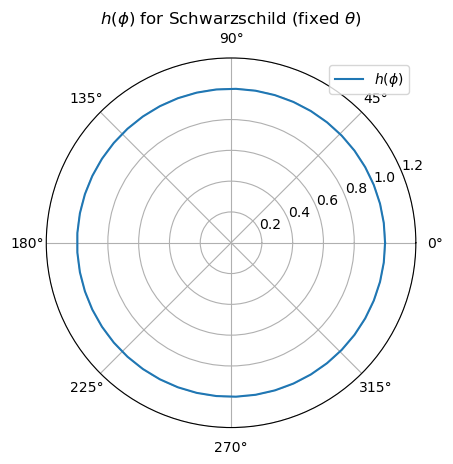

In [6]:
'''
Make polar plot of h(phi)
'''

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, sol_h, label=r"$h(\phi)$")
ax.set_rmax(1.2)
ax.grid(True)
ax.legend(loc='upper right')
plt.title(r"$h(\phi)$ for Schwarzschild (fixed $\theta$)")
plt.show()